
Average xG per corner (Horsens): 0.03
Total xG from corner (Horsens): 1.4
Number of corners (Horsens): 42


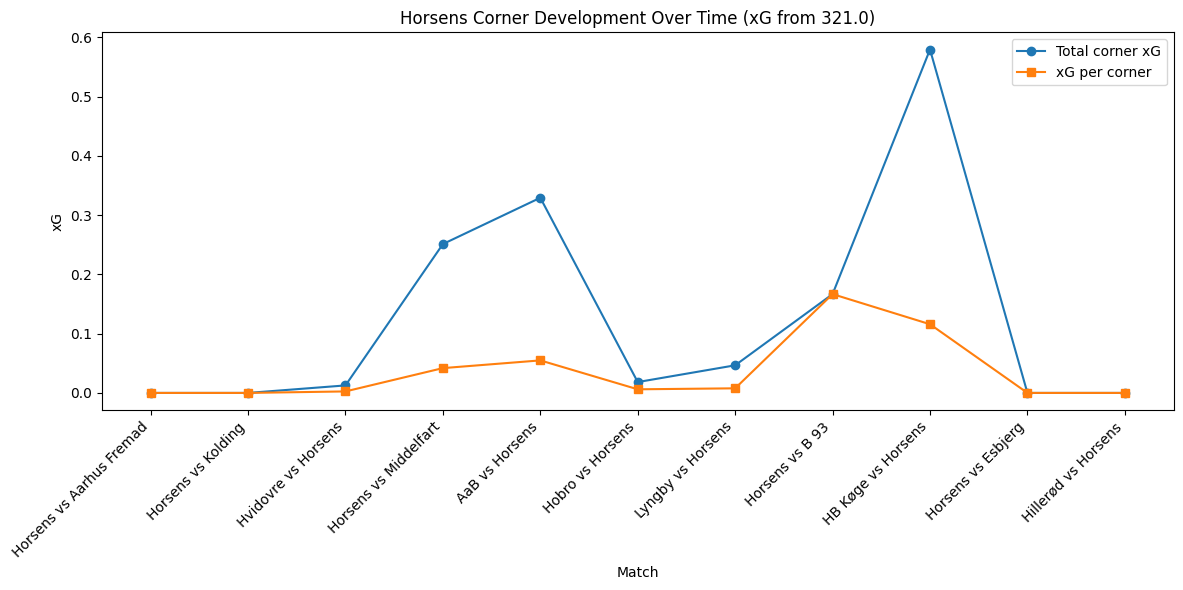


=== League table: Corner (xG per piece, total xG, count) ===
        team_name  xG_per_piece  xG_total  corner_taken
6           Hobro          0.05      2.66            51
5        Hillerød          0.04      1.75            47
8        Hvidovre          0.04      2.20            51
0             AaB          0.03      1.82            58
2            B 93          0.03      1.50            53
4         HB Køge          0.03      0.91            36
7         Horsens          0.03      1.40            42
1   Aarhus Fremad          0.02      1.52            62
3         Esbjerg          0.02      1.14            50
9         Kolding          0.02      1.07            60
10         Lyngby          0.02      0.98            47
11     Middelfart          0.02      0.91            41

Average xG per freekick (Horsens): 0.01
Total xG from freekick (Horsens): 0.73
Number of freekicks (Horsens): 128


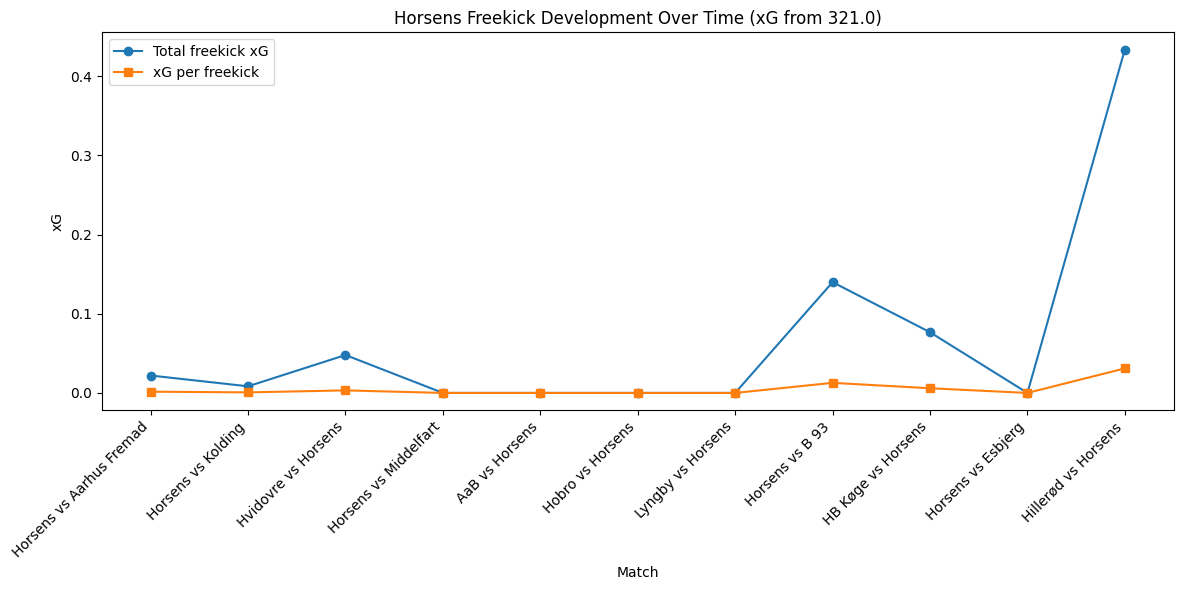


=== League table: Freekick (xG per piece, total xG, count) ===
        team_name  xG_per_piece  xG_total  freekick_taken
8        Hvidovre          0.02      1.93             119
0             AaB          0.01      0.71             140
3         Esbjerg          0.01      0.73             110
4         HB Køge          0.01      1.23             125
6           Hobro          0.01      0.84             136
7         Horsens          0.01      0.73             128
9         Kolding          0.01      1.06             125
10         Lyngby          0.01      1.16             149
1   Aarhus Fremad          0.00      0.56             129
2            B 93          0.00      0.09             157
5        Hillerød          0.00      0.46             146
11     Middelfart          0.00      0.15             142

Average xG per long throw-in (Horsens): 0.01
Total xG from long throw-ins (Horsens): 0.3
Number of long throw-ins (Horsens): 41


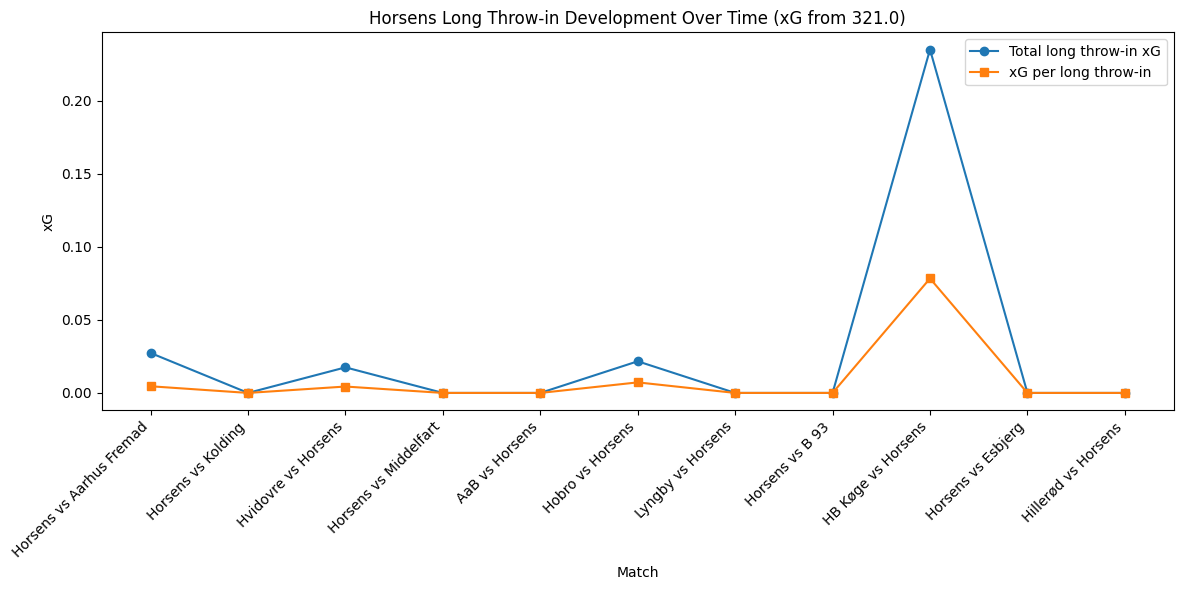


=== League table: Long Throw-ins (xG per throw-in, total xG, count) ===
        team_name  xG_per_throwin  xG_total  long_throwins_taken
4         HB Køge            0.02      0.79                   51
5        Hillerød            0.02      0.47                   25
6           Hobro            0.02      0.71                   45
1   Aarhus Fremad            0.01      0.22                   42
2            B 93            0.01      0.27                   37
3         Esbjerg            0.01      0.48                   53
7         Horsens            0.01      0.30                   41
8        Hvidovre            0.01      0.58                   46
9         Kolding            0.01      0.68                   51
0             AaB            0.00      0.05                   34
10         Lyngby            0.00      0.01                   40
11     Middelfart            0.00      0.21                   54


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Load data ---
df = pd.read_csv(
    r'C:\Users\Seamus-admin\Documents\GitHub\AC-Horsens-First-Team\DNK_1_Division_2025_2026\set_piece_DNK_1_Division_2025_2026.csv'
)

# Function to process any set piece type
def process_set_piece(df, piece_type, extra_filter=None, title="Set Piece"):
    # --- Filter specific set piece type ---
    pieces = df[df['set_piece_type'] == piece_type].copy()
    
    # Apply extra filter if provided
    if extra_filter is not None:
        pieces = pieces.query(extra_filter)
    
    # Sort so IDs are sequential
    pieces = pieces.sort_values(['match_id', 'team_name', 'date', 'set_piece_index'])
    
    # Create running unique set piece ID (new ID whenever index == 1)
    pieces['set_piece_uid'] = (pieces['set_piece_index'] == 1).cumsum()
    
    # Corner type is only relevant for corners, but keep column for consistency
    pieces['corner_type'] = pieces.apply(
        lambda row: 'inswinger' if row.get('223.0', 0) == 1 
        else ('outswinger' if row.get('224.0', 0) == 1 else 'other'),
        axis=1
    )
    
    # Aggregate to set-piece level (xG only from 321.0)
    agg_pieces = (
        pieces.groupby(['set_piece_uid', 'match_id', 'team_name', 'date', 'label'])
        .agg(
            corner_type=('corner_type', lambda x: 'inswinger' if 'inswinger' in x.values 
                         else 'outswinger' if 'outswinger' in x.values else 'other'),
            xG=('321.0', 'sum')   # total xG from shots in this set piece
        )
        .reset_index()
    )
    
    # --- Horsens only ---
    horsens_pieces = agg_pieces[agg_pieces['team_name'] == 'Horsens']
    
    # Horsens stats
    xg_per_piece = horsens_pieces['xG'].mean()
    xg_total_pieces = horsens_pieces['xG'].sum()
    num_pieces_horsens = horsens_pieces['set_piece_uid'].nunique()
    
    print(f"\nAverage xG per {piece_type} (Horsens):", round(xg_per_piece, 2))
    print(f"Total xG from {piece_type} (Horsens):", round(xg_total_pieces, 2))
    print(f"Number of {piece_type}s (Horsens):", num_pieces_horsens)
    
    # Over time
    xg_over_time = horsens_pieces.groupby(['date', 'label'])['xG'].sum().reset_index()
    xg_per_piece_over_time = horsens_pieces.groupby(['date', 'label'])['xG'].mean().reset_index()
    
    # Plot Horsens development over time
    plt.figure(figsize=(12,6))
    plt.plot(xg_over_time['label'], xg_over_time['xG'], marker='o', label=f"Total {piece_type} xG")
    plt.plot(xg_per_piece_over_time['label'], xg_per_piece_over_time['xG'], marker='s', label=f"xG per {piece_type}")
    
    plt.title(f"Horsens {title} Development Over Time (xG from 321.0)")
    plt.xlabel("Match")
    plt.ylabel("xG")
    plt.legend()
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()
    
    # --- League-wide rankings with counts ---
    xg_per_piece_team = agg_pieces.groupby('team_name')['xG'].mean().reset_index()
    xg_total_pieces_team = agg_pieces.groupby('team_name')['xG'].sum().reset_index()
    pieces_count_team = (
        agg_pieces.groupby('team_name')['set_piece_uid']
        .nunique()
        .reset_index()
        .rename(columns={'set_piece_uid': f'{piece_type}_taken'})
    )
    
    xg_table = (
        xg_per_piece_team
        .merge(xg_total_pieces_team, on='team_name', suffixes=('_per_piece', '_total'))
        .merge(pieces_count_team, on='team_name')
        .round(2)
        .sort_values('xG_per_piece', ascending=False)
    )
    
    print(f"\n=== League table: {title} (xG per piece, total xG, count) ===")
    print(xg_table)
    
    return agg_pieces


# --- Process corners ---
agg_corners = process_set_piece(df, "corner", title="Corner")

# --- Process freekicks ---
agg_freekicks = process_set_piece(df, "freekick", title="Freekick")


# --- Long throw-ins in final third ---
throwins = df[df['set_piece_type'] == 'throw_in'].copy()

# Make sure numeric
throwins['x'] = pd.to_numeric(throwins['x'], errors='coerce')
throwins['212.0'] = pd.to_numeric(throwins['212.0'], errors='coerce')

# Sort
throwins = throwins.sort_values(['match_id', 'team_name', 'date', 'set_piece_index'])

# Create running set piece UID
throwins['set_piece_uid'] = (throwins['set_piece_index'] == 1).cumsum()

# Identify long throw-ins in final third
long_throwins = throwins[(throwins['x'] > 66) & (throwins['212.0'] > 15)]
long_throwin_ids = long_throwins['set_piece_uid'].unique()

# Get all actions from those throw-in sequences
long_throwin_sequences = throwins[throwins['set_piece_uid'].isin(long_throwin_ids)].copy()

# Aggregate
agg_long_throwins = (
    long_throwin_sequences.groupby(['set_piece_uid', 'match_id', 'team_name', 'date', 'label'])
    .agg(xG=('321.0', 'sum'))
    .reset_index()
)

# Horsens stats
horsens_long_throwins = agg_long_throwins[agg_long_throwins['team_name'] == 'Horsens']
xg_per_throwin = horsens_long_throwins['xG'].mean()
xg_total_throwins = horsens_long_throwins['xG'].sum()
num_throwins_horsens = horsens_long_throwins['set_piece_uid'].nunique()

print("\nAverage xG per long throw-in (Horsens):", round(xg_per_throwin, 2))
print("Total xG from long throw-ins (Horsens):", round(xg_total_throwins, 2))
print("Number of long throw-ins (Horsens):", num_throwins_horsens)

# Over time plot
xg_over_time_throwin = horsens_long_throwins.groupby(['date', 'label'])['xG'].sum().reset_index()
xg_per_throwin_over_time = horsens_long_throwins.groupby(['date', 'label'])['xG'].mean().reset_index()

plt.figure(figsize=(12,6))
plt.plot(xg_over_time_throwin['label'], xg_over_time_throwin['xG'], marker='o', label="Total long throw-in xG")
plt.plot(xg_per_throwin_over_time['label'], xg_per_throwin_over_time['xG'], marker='s', label="xG per long throw-in")

plt.title("Horsens Long Throw-in Development Over Time (xG from 321.0)")
plt.xlabel("Match")
plt.ylabel("xG")
plt.legend()
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# --- League-wide long throw-in table ---
xg_per_throwin_team = agg_long_throwins.groupby('team_name')['xG'].mean().reset_index()
xg_total_throwins_team = agg_long_throwins.groupby('team_name')['xG'].sum().reset_index()
throwins_count_team = (
    agg_long_throwins.groupby('team_name')['set_piece_uid']
    .nunique()
    .reset_index()
    .rename(columns={'set_piece_uid': 'long_throwins_taken'})
)

xg_table_throwins = (
    xg_per_throwin_team
    .merge(xg_total_throwins_team, on='team_name', suffixes=('_per_throwin', '_total'))
    .merge(throwins_count_team, on='team_name')
    .round(2)
    .sort_values('xG_per_throwin', ascending=False)
)

print("\n=== League table: Long Throw-ins (xG per throw-in, total xG, count) ===")
print(xg_table_throwins)
